# <center> Neural Network : Assignment 1 </center>
**Build a neural network with 4 layers (3 weight layers) using Python Programming where Mean Squared Error and sigmoid activation function should be employed as its loss function and activation function, respectively. Also, momentum term should be included in this basic Neural Network structure and Batch Gradient Descent should be used for training.  The MNIST data set is available at**   **http://yann.lecun.com/exdb/mnist/**

### Librairies
This notebook uses Python 3 environment, which comes with many helpful analytics libraries installed.

In this project, here are the packages we will need


In [88]:
# linear algebra
import numpy as np
from random import randint


# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# scipy.special for sigmoid function
import scipy.special

# visualizations
import matplotlib.pyplot
from tqdm import tqdm

%matplotlib inline

# Data import

from keras.datasets import mnist
from keras.utils import np_utils
import time

np.random.seed(42)


# Construction Phase
In this project, we want to build a neural network with 4 layers (3 weight layers)
-     Input layer : initial data for the neural network.
-     2 Hidden Layers : intermediate layer between input and output layer and place where all the computation is done.
-     Output layer — produce the result for given inputs.

<img src="files/neural_network.png" >



<img src="files/back_propagation.png" >
<p> <b> Backpropagation algorithmn </b> : The output values are compared with the correct answer to compute the value of some predefined error-function. By various techniques, the error is then fed back through the network. Using this information, the algorithm adjusts the weights of each connection in order to reduce the value of the error function by some small amount. After repeating this process for a sufficiently large number of training cycles, the network will usually converge to some state where the error of the calculations is small. In this case, one would say that the network has learned a certain target function. To adjust weights properly, one applies a general method for non-linear optimization that is called gradient descent. For this, the network calculates the derivative of the error function with respect to the network weights, and changes the weights such that the error decreases (thus going downhill on the surface of the error function). For this reason, back-propagation can only be applied on networks with differentiable activation functions. </p>

In [89]:
# Base Layer class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # Input X is computed into the output Y for every layers
    def forwardProp(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backwardProp(self, output_error, learning_rate):
        raise NotImplementedError

Each node is connected with each node from the next layer and each connection (black arrow) has particular weight. Weight can be seen as impact that that node has on the node from the next layer. So if we take a look on one node it would look like this <img src="files/tempsnip.png" >

---
A node, also called a neuron or Perceptron, is a computational unit that has one or more weighted input connections, a activation function that combines the inputs in some way, and an output connection.

Nodes are then organized into layers to comprise a network.

---
### Activation function

Activation function decides, whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.

In this project, we use the Sigmoid function as activation function. It is one of the most widely used activation function today. It equation is given with the formula below.
Because of this properties ( it is a non linear function ), it allows the nodes to take any values between 0 and 1. In the end, in case of multiple output classes, this would result with different probabilities of “activation” for each output class. And we will choose the one with the highest “activation”(probability) value.

In [90]:
# activation function and its derivative
def sigmoidFunction(x):
    return (1/(1+np.exp(-x)))

def sigmoidFunction_derivative(x):
    return (1-(1/(np.exp(x)+1)))*(1/(1+np.exp(x)))

---
### Loss Function

In [91]:
# loss function and its derivative
def mse_loss(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_loss_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

---
Creation of the Full Connected Layer, which inherit from the Layer class

---
We initialize the class with a bias value, that allows to shift the activation function to the left or right and it helps getting better fit for the data (better prediction function as output.


We also initialize the weights with random values ; 

In [92]:
# inherit from base class Layer
class Dense(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, inputSize, outputSize):
        self.weights = np.random.rand(inputSize, outputSize) - 0.5
        self.bias = np.random.rand(1, outputSize) - 0.5

    # returns output for a given input
    def forwardProp(self, inputData):
        self.input = inputData
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given outputError=dE/dY. Returns inputError=dE/dX.
    def backwardProp(self, outputError, learningRate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        # dBias = outputError

        # update parameters
        self.weights -= learningRate * weightsError
        self.bias -= learningRate * outputError
        return inputError

---
- Creation of the Activate Class, which will allow to activate each note of the Layer.

In [93]:
# inherit from base class Layer
class ActivateLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forwardProp(self, inputData):
        self.input = inputData
        self.output = self.activation(self.input)
        return self.output

    # Returns inputError=dE/dX for a given outputError=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backwardProp(self, outputError, learningRate):
        return self.activation_prime(self.input) * outputError

---
# Execution Phase

In [94]:
class neuralNetwork:
    def __init__(self):
        self.layers = []
        self.mse_loss= None
        self.mse_loss_derivative = None

    # add layer to network
    def add_layer(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use_lossfunc(self, mse_loss, mse_loss_derivative):
        self.mse_loss = mse_loss
        self.mse_loss_derivative = mse_loss_derivative

    # predict output for given input
    def predict_output(self, inputData):
        # sample dimension first
        samples = len(inputData)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = inputData[i]
            for layer in self.layers:
                output = layer.forwardProp(output)
            result.append(output)

        return result

    # train the network
    def train_network(self, x_train, y_train, epochs, learningRate):
        # sample dimension first
        samples = len(x_train)
        errorList = []
        for i in tqdm(range(epochs)):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forwardProp(output)

                # compute loss (for display purpose only)
                #err += self.loss(y_train[j], output)

                # backward propagation
                error = self.mse_loss_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backwardProp(error, learningRate)
                    
            # calculate average error on all samples
            err /= samples
            errorList.append(err)
            
        # show error's graph
        #plt.plot(errorList)
        #plt.ylabel('Error')
        #print("Last error : %f" %(errorList[-1]))
        return errorList[-1]
    
    def plot_learning_curves(self, X_train, X_test, y_train, y_test, size, iterations, learning_rate):
        train_errors, test_errors = [], []

        self.train_network(X_train[:size], y_train[:size], epochs=iterations, learningRate=learning_rate)

        labels_train_predict = self.predict_output(X_train[:size])
        labels_test_predict = self.predict_output(X_test[:size])

        for m in range(1, size):
            train_errors.append(mse_loss(y_train[:m], labels_train_predict))
            print(train_errors)
            test_errors.append(mse_loss(y_test[:m], labels_test_predict))
            print(test_errors)

        #plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
        #plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
        #plt.legend(loc="upper right", fontsize=14)
        #plt.xlabel("Training set size", fontsize=14)
        plt.plot(train_errors,label='train accuracy')
        plt.plot(test_errors,label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
        
        

### MNIST Data
---
- The MNIST-Database is a large dataset of 70.000 handwritten digits that are mainly used for training several image processing systems, especially in the deeplearning field.
- The dataset consists digits from 0 to 9 in a 28x28 pixel based format. The values are stored in a comma separted file in which each row has 785 values (28x28 = 784) where every row represents a different number that is initially displayed in the first value of the row (784 + 1).

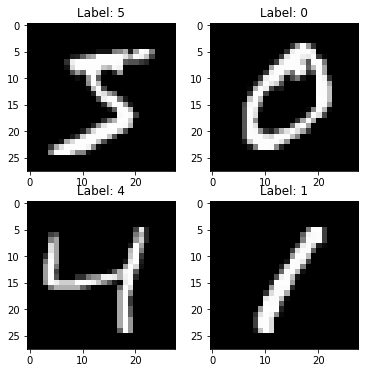

In [95]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
        return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

- The MNIST-Dataset consists 28x28 pixel based information of digits, that are rowbased stored in a comma separated file (in this example). Therefore we need to split the values and bring them into shapes of 28x28-array to visualize and work with the "pictures".

- Every field of the 28x28-array will represent a number value that is correspondent to a grey scaled color between 0 and 255.


In [96]:
# training data : 60000 samples
# reshape and normalize input data
X_train = X_train.reshape(X_train.shape[0], 1, 28*28)
X_train = X_train.astype('float32')
X_train /= 255
# transform the output (number from 0 to 9) into a vector
# for example: number 2 will become [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
X_test = X_test.reshape(X_test.shape[0], 1, 28*28)
X_test = X_test.astype('float32')
X_test /= 255
y_test = np_utils.to_categorical(y_test)


### Learning Curves
---
Plot of the learning curve

---


We’ll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.01it/s]


[0.023732899399072114]
[0.1939930029519424]
[0.023732899399072114, 0.10650997507211737]
[0.1939930029519424, 0.19290871082134012]
[0.023732899399072114, 0.10650997507211737, 0.13278388862555016]
[0.1939930029519424, 0.19290871082134012, 0.1834398091752571]
[0.023732899399072114, 0.10650997507211737, 0.13278388862555016, 0.1407062070608166]
[0.1939930029519424, 0.19290871082134012, 0.1834398091752571, 0.1849073477516186]
[0.023732899399072114, 0.10650997507211737, 0.13278388862555016, 0.1407062070608166, 0.1509097235668623]
[0.1939930029519424, 0.19290871082134012, 0.1834398091752571, 0.1849073477516186, 0.1849985766444406]
[0.023732899399072114, 0.10650997507211737, 0.13278388862555016, 0.1407062070608166, 0.1509097235668623, 0.15772521061052672]
[0.1939930029519424, 0.19290871082134012, 0.1834398091752571, 0.1849073477516186, 0.1849985766444406, 0.18158248151754902]
[0.023732899399072114, 0.10650997507211737, 0.13278388862555016, 0.1407062070608166, 0.1509097235668623, 0.1577252106105

[0.023732899399072114, 0.10650997507211737, 0.13278388862555016, 0.1407062070608166, 0.1509097235668623, 0.15772521061052672, 0.15868920371853948, 0.1620543637341816, 0.16232311913778544, 0.16462397879724847, 0.16653184289237832, 0.1546319309346028, 0.15701489654299314, 0.15947613455210544, 0.1598092697397395, 0.16194272581760533, 0.16369919170061964, 0.16516335694898626, 0.16654803440801677, 0.16780682216716822]
[0.1939930029519424, 0.19290871082134012, 0.1834398091752571, 0.1849073477516186, 0.1849985766444406, 0.18158248151754902, 0.1821226259030033, 0.183325008587097, 0.16559382338990974, 0.16820860978849408, 0.17012691466960397, 0.17190727091655875, 0.17343299525957367, 0.17456706441822578, 0.17389606051588347, 0.16451157809691647, 0.1661133492309657, 0.16766221888213106, 0.1686062729798398, 0.16944413394163424]
[0.023732899399072114, 0.10650997507211737, 0.13278388862555016, 0.1407062070608166, 0.1509097235668623, 0.15772521061052672, 0.15868920371853948, 0.1620543637341816, 0.16

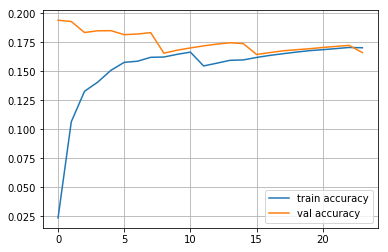

In [159]:
def run_net(Layer1, Layer2, epochs):
    # Network (3 weigthed layers)
    network = neuralNetwork()
    network.add_layer(Dense(28*28, Layer1))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
    network.add_layer(Dense(Layer1, Layer2))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))
    network.add_layer(Dense(Layer2, 10))
    network.add_layer(ActivateLayer(sigmoidFunction, sigmoidFunction_derivative))

    # train on 1000 samples
    # training will be slow if we update at each iteration on 60000 samples
    # compromise with 250 epochs for the precision & time with L1 of 100 and L2 of 50 neurons
    network.use_lossfunc(mse_loss, mse_loss_derivative)
    #network.train_network(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1)
    network.plot_learning_curves(X_train[0:1000], X_test[0:1000], y_train[0:1000], y_test[0:1000], size=epochs, iterations=25, learning_rate=0.01)


predict_digit = run_net(300, 100, 25)
# input_layer : 784 nodes
# Hidden Layer 1 : 300 nodes
# Hidden Layer 2 : 100 nodes
time.sleep(1)


# B. Using a ReLU activation function

In [143]:
def ReLU(x):
    return x * (x > 0)

def dReLU(x):
    return 1. * (x > 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.06it/s]


[0.09689822126403984]
[0.10046600348968912]
[0.09689822126403984, 0.09851980446143815]
[0.10046600348968912, 0.10046600348968913]
[0.09689822126403984, 0.09851980446143815, 0.09906033219390427]
[0.10046600348968912, 0.10046600348968913, 0.10046600348968912]
[0.09689822126403984, 0.09851980446143815, 0.09906033219390427, 0.09933059606013732]
[0.10046600348968912, 0.10046600348968913, 0.10046600348968912, 0.10046600348968912]
[0.09689822126403984, 0.09851980446143815, 0.09906033219390427, 0.09933059606013732, 0.09949275437987715]
[0.10046600348968912, 0.10046600348968913, 0.10046600348968912, 0.10046600348968912, 0.10046600348968912]
[0.09689822126403984, 0.09851980446143815, 0.09906033219390427, 0.09933059606013732, 0.09949275437987715, 0.09960085992637038]
[0.10046600348968912, 0.10046600348968913, 0.10046600348968912, 0.10046600348968912, 0.10046600348968912, 0.10046600348968912]
[0.09689822126403984, 0.09851980446143815, 0.09906033219390427, 0.09933059606013732, 0.09949275437987715, 

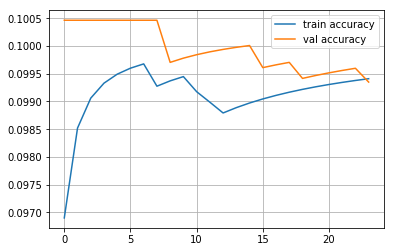

In [136]:
def run_net(Layer1, Layer2, epochs):
    # Network (3 weigthed layers)
    network = neuralNetwork()
    network.add_layer(Dense(28*28, Layer1))
    network.add_layer(ActivateLayer(ReLU, dReLU))
    network.add_layer(Dense(Layer1, Layer2))
    network.add_layer(ActivateLayer(ReLU,dReLU))
    network.add_layer(Dense(Layer2, 10))
    network.add_layer(ActivateLayer(ReLU, dReLU))

    # train on 1000 samples
    # training will be slow if we update at each iteration on 60000 samples
    # compromise with 250 epochs for the precision & time with L1 of 100 and L2 of 50 neurons
    network.use_lossfunc(mse_loss, mse_loss_derivative)
    #network.train_network(X_train[0:1000], y_train[0:1000], epochs, learningRate=0.1)
    network.plot_learning_curves(X_train[0:1000], X_test[0:1000], y_train[0:1000], y_test[0:1000], size=epochs, iterations=25, learning_rate=0.01)


predict_digit = run_net(300, 100, 25)
# input_layer : 784 nodes
# Hidden Layer 1 : 300 nodes
# Hidden Layer 2 : 100 nodes
